# A Neural Algorithm of Artistic Style in TensorFlow

In this notebook we will implement the style transfer technique from the paper "[A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576)".

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic “style” of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep neural network, and then performing gradient descent on the pixels of the image itself.

## Setup

In [1]:
# Import what we need
#!pip3 install --upgrade scipy
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

### Model

We need to take the advatange of a CNN structure which (implicitly) understands image contents and styles. Rather than training a completely new model from scratch, we will use a pre-trained model to achieve our purpose - called "transfer learning".

We will use the VGG19 model. Since the model itself is very large (>500Mb) you will need to download the [VGG-19 model](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat) and put it under the `model/` folder. The comments below describes the dimensions of the VGG19 model. We will replace the max pooling layers with average pooling layers as the paper suggests, and discard all fully connected layers.

In [10]:
# Pick the VGG 19-layer model by from the paper "Very Deep Convolutional 
# Networks for Large-Scale Image Recognition".
VGG_MODEL = 'model/imagenet-vgg-verydeep-19.mat'

# In order to use this VGG model we need to substract the mean of the images
# originally used to train the VGG model from the new input images to be consistent.
# This affects the performance greatly.
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,3))

def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

### Input Images

Here we define some constants for the inputs. For this notebook, we will be using RGB images with a 640 x 480 resolution, but you can easily modify the code to accommodate for different sizes.

In [1]:
# Output folder for the images.
OUTPUT_DIR = 'output/'
# Style image to use.
STYLE_IMAGE = 'images/muse.jpg'
# Content image to use.
CONTENT_IMAGE = 'images/trojan_shrine.jpg'
# Image dimensions constants. 
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480
COLOR_CHANNELS = 3

def load_image(path):
    image_raw = scipy.misc.imread(path)
    # Resize the image for convnet input and add an extra dimension
    image_raw = scipy.misc.imresize(image_raw, (IMAGE_HEIGHT, IMAGE_WIDTH))
    # Input to the VGG model expects the mean to be subtracted.
    image = (image_raw - MEAN_VALUES)
    return [image_raw, image]

def recover_image(image):
    image_raw = image + MEAN_VALUES
    image_raw = np.clip(image_raw, 0, 255).astype('uint8')
    return image_raw

def save_image(path, image):
    # Output should add back the mean.
    image = recover_image(image)
    scipy.misc.imsave(path, image)

Now we load the input images. The vgg model expects image data with MEAN_VALUES subtracted to function correctly. "load_image" already handles this. The subtracted images will look funny.

In [2]:
[content_image_raw, content_image] = load_image(CONTENT_IMAGE)
[style_image_raw, style_image] = load_image(STYLE_IMAGE)

fig = plt.figure(figsize=(10,10))   
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

def normalize(image):
    return (1.*image - np.min(image))/(np.max(image) - np.min(image))

ax1.imshow(content_image_raw)
ax1.set_title('Content Image')
ax2.imshow(content_image)
ax2.set_title('Content Image Subtracted')
ax3.imshow(style_image_raw)
ax3.set_title('Style Image')
ax4.imshow(style_image)
ax4.set_title('Style Image Subtracted')

# Show the resulting image
plt.show()

NameError: global name 'scipy' is not defined

## Random Image Generator

The first step of style tranfer is to generate a starting image. The model will then gradually adjust this starting image towards target content/style. We will need a random image generator.

The generated image can be arbitrary and doesn't necessarily have anything to do with the content image. But, generating something similar to the content image will reduce our computing time.

In [2]:
def generate_noise_image(content_image, noise_ratio):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.randn(IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)
    #Take a weighted average of the values
    gen_image = noise_image * noise_ratio + content_image * (1.0 - noise_ratio)
    return gen_image

Now let's check by visualize images you generated. Keep in mind that `noise_ratio = 0.0` produces the original subtracted image, while `noise_ratio = 1.0` produces a complete random noise.

In [5]:
fig = plt.figure(figsize=(10,10))   
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
gen_image = generate_noise_image(content_image, 0.0)
ax1.imshow(gen_image)
ax1.set_title('Noise ratio: 0.0')
gen_image = generate_noise_image(content_image, 0.25)
ax2.imshow(gen_image)
ax2.set_title('Noise ratio: 0.25')
gen_image = generate_noise_image(content_image, 0.50)
ax3.imshow(gen_image)
ax3.set_title('Noise ratio: 0.50')
gen_image = generate_noise_image(content_image, 0.75)
ax4.imshow(gen_image)
ax4.set_title('Noise ratio: 0.75')


NameError: name 'content_image' is not defined

## Loss Functions
Once we generate a new image, we would like to evaluate it by how much it maintains contents while approaches the target style.
This can be defined by a loss function. The loss function is a weighted sum of two terms: content loss + style loss. 
You'll fill in the functions that compute these weighted terms below.
### Content Loss
Let's first write the content loss function of equation (1) from the paper. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times H_\ell \times W_\ell \times N_\ell}$. $N_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{M_\ell \times N_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{M_\ell \times N_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image.

Then the content loss is given by:

$L_c = \frac{1}{2} \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

We are only concerned with the "conv4_2" layer of the model.

In [3]:
CONTENT_LAYER = 'conv4_2'

def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(current_feat, content_feat):
        """
        Inputs:
        - current_feat: features of the current image, Tensor with shape [1, height, width, channels]
        - content_feat: features of the content image, Tensor with shape [1, height, width, channels]

        Returns:
        - scalar content loss
        """
        loss = 0.5*tf.reduce_sum(tf.square(current_feat - content_feat))
        return loss
    return _content_loss(sess.run(model[CONTENT_LAYER]), model[CONTENT_LAYER])

### Style Loss

Now we can tackle the style loss of equation (5) from the paper. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(1, M_\ell,  N_\ell)$, the Gram matrix has shape $(1, N_\ell, N_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, then the style loss for the layer $\ell$ is simply the Euclidean distance between the two Gram matrices:

$$E_\ell = \frac{1}{4 N^2_\ell M^2_\ell} \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the weighted sum of style losses at each layer by $w_\ell$:

$$L_s = \sum_{\ell \in \mathcal{L}}  w_\ell E_\ell$$

In our case it is a summation from conv1_1 (lower layer) to conv5_1 (higher layer). Intuitively, the style loss across multiple layers captures lower level features (hard strokes, points, etc) to higher level features (styles, patterns, even objects). 

In [4]:
# Layers to use. We will use these layers as advised in the paper.
# To have softer features, increase the weight of the higher layers
# (conv5_1) and decrease the weight of the lower layers (conv1_1).
# To have harder features, decrease the weight of the higher layers
# (conv5_1) and increase the weight of the lower layers (conv1_1).
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 0.5),
    ('conv3_1', 0.5),
    ('conv4_1', 0.5),
    ('conv5_1', 0.5),
]

def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(feat):
        """
        Compute the Gram matrix from features.

        Inputs:
        - feat: Tensor of shape (1, H, W, C) giving features for a single image.

        Returns:
        - gram: Tensor of shape (C, C) giving the (optionally normalized) Gram matrices for the input image.
        """
        tensor = feat
        shape = tensor.get_shape()
    
        # Get the number of feature channels for the input tensor,
        # which is assumed to be from a convolutional layer with 4-dim.
        num_channels = int(shape[3])

        # Reshape the tensor so it is a 2-dim matrix. This essentially
        # flattens the contents of each feature-channel.
        matrix = tf.reshape(tensor, shape=[-1, num_channels])

        # Calculate the Gram-matrix as the matrix-product of
        # the 2-dim matrix with itself. This calculates the
        # dot-products of all combinations of the feature-channels.
        gram = tf.matmul(tf.transpose(matrix), matrix)
        return gram
    
    def _style_loss(current_feat, style_feat):
        """
        Inputs:
        - current_feat: features of the current image, Tensor with shape [1, height, width, channels]
        - style_feat: features of the style image, Tensor with shape [1, height, width, channels]

        Returns:
        - scalar style loss
        """
        assert (current_feat.shape == style_feat.shape)
        H = current_feat.shape[1]
        W = current_feat.shape[2]
        M = H * W
        
        N = current_feat.shape[3]
        
        current_feat = tf.convert_to_tensor(current_feat)
        
        gram_current = _gram_matrix(current_feat)
        gram_style = _gram_matrix(style_feat)
        
        loss = 1/(4 * (N ** 2) * (M ** 2)) * tf.reduce_sum(tf.square(gram_current - gram_style))
        return loss

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

Create an TensorFlow session.

In [36]:
sess = tf.InteractiveSession()

In [37]:
# Load VGG model
model = load_vgg_model(VGG_MODEL)

Build the model now.

In [38]:
# Construct content_loss using content_image.
content_image_list = np.reshape(content_image, ((1,) + content_image.shape))
sess.run(model['input'].assign(content_image_list))
content_loss = content_loss_func(sess, model)

In [39]:
# Construct style_loss using style_image.
style_image_list = np.reshape(style_image, ((1,) + style_image.shape))
sess.run(model['input'].assign(style_image_list))
style_loss = style_loss_func(sess, model)

### Total loss
$$L = \alpha L_c + \beta L_s$$

In [40]:
# Constant to put more emphasis on content loss.
ALPHA = 0.0025
# Constant to put more emphasis on style loss.
BETA = 1
# Instantiate equation 7 of the paper.
total_loss = ALPHA * content_loss + BETA * style_loss

In [41]:
# We minimize the total_loss, which is the equation 7.
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

## Finally! Run!
Now we run the model which outputs the painted image every 100 iterations. You can find those intemediate results under `output/` folder. Notice on CPU it usually takes almost an hour to run 1000 iterations. Take your time!

In [42]:
# Number of iterations to run.
ITERATIONS = 500

Iteration 0
cost:  1.25414e+09


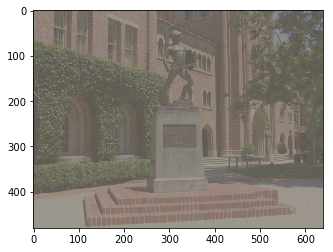

Iteration 50
cost:  1.9037e+08


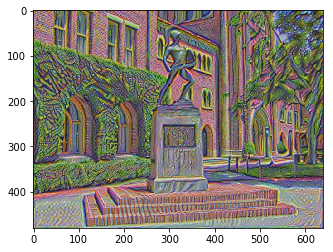

Iteration 100
cost:  1.40426e+08


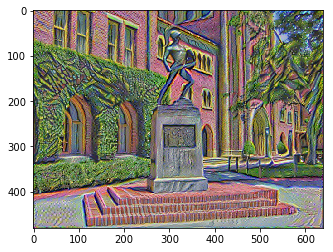

Iteration 150
cost:  1.24668e+08


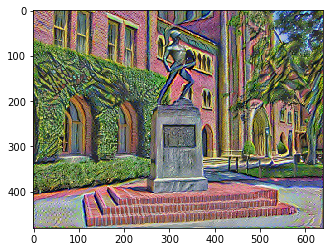

Iteration 200
cost:  1.17292e+08


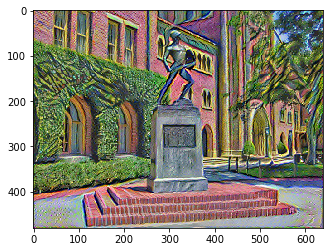

Iteration 250
cost:  1.13022e+08


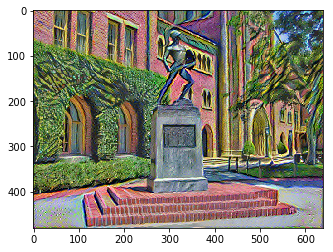

Iteration 300
cost:  1.10259e+08


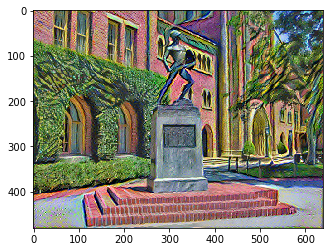

Iteration 350
cost:  1.08322e+08


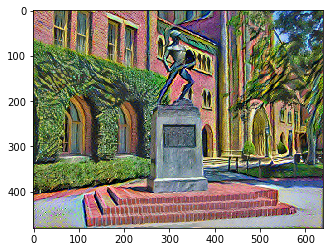

Iteration 400
cost:  1.06857e+08


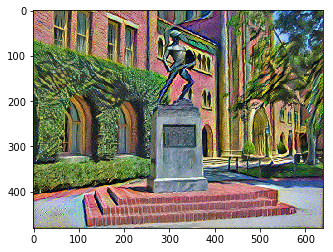

Iteration 450
cost:  1.05697e+08


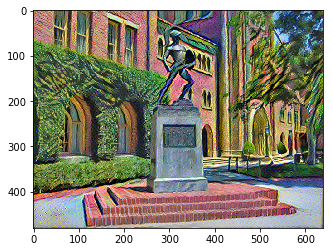

In [43]:
sess.run(tf.global_variables_initializer())
input_image = np.reshape(gen_image, ((1,) + gen_image.shape))
sess.run(model['input'].assign(input_image))
for it in range(ITERATIONS):
    sess.run(train_step)
    #print('Iteration %d' % (it))
    if it%50 == 0:
        # Print every 50 iterations.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        save_image(filename, mixed_image[0])
        
        final_image = recover_image(mixed_image[0]);
        imshow(final_image)
        plt.show()